In [1]:
import cartopy.crs as ccrs
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegFileWriter
from IPython.display import HTML
import numpy as np
from itertools import product
import pandas as pd
import os
import rasterio.warp as rasteriowarp

In [2]:
SATELLITE_DATA_PATH = '/storage/data/eumetsat/native/reprojected2/'
PV_DATA_FILENAME = '~/data/pvoutput.org/UK_PV_timeseries_batch.nc'
PV_METADATA_FILENAME = '~/data/pvoutput.org/UK_PV_metadata.csv'

DST_CRS = {
    'ellps': 'WGS84',
    'proj': 'tmerc',  # Transverse Mercator
    'units': 'm'  # meters
}

# Boundary in Transverse Mercator (meters)
NORTH = 5513500
SOUTH = 6613500
WEST =  -889500
EAST =   410500

## Load and convert PV metadata

In [3]:
pv_metadata = pd.read_csv(PV_METADATA_FILENAME, index_col='system_id').dropna(subset=['longitude', 'latitude'], how='any')

In [4]:
# Convert lat lons to Transverse Mercator
reprojected_x, reprojected_y = rasteriowarp.transform(
    src_crs={'init': 'EPSG:4326'},
    dst_crs=DST_CRS,
    xs=pv_metadata['longitude'].values,
    ys=pv_metadata['latitude'].values)

pv_metadata['x'] = reprojected_x
pv_metadata['y'] = reprojected_y

# Filter 3 PV systems which apparently aren't in the UK!
pv_metadata = pv_metadata[
    (pv_metadata.x >= WEST) &
    (pv_metadata.x <= EAST) &
    (pv_metadata.y >= NORTH) &
    (pv_metadata.y <= SOUTH)
]

len(pv_metadata)

2548

## Load and normalise PV power data

In [5]:
%%time
pv_power = xr.load_dataset(PV_DATA_FILENAME)

CPU times: user 14.5 s, sys: 2.31 s, total: 16.8 s
Wall time: 17.2 s


In [191]:
pv_power_selected = pv_power.loc[dict(datetime=slice('2019-01-01', '2019-01-20'))]

In [192]:
pv_power_df = pv_power_selected.to_dataframe().dropna(axis='columns', how='all')
pv_power_df = pv_power_df.clip(lower=0, upper=5E7)
pv_power_df.columns = [np.int64(col) for col in pv_power_df.columns]

In [193]:
# A bit of hand-crafted cleaning
pv_power_df[30248][:'2019-01-03'] = np.NaN

In [194]:
# Normalise
pv_power_df -= pv_power_df.min()
pv_power_df /= pv_power_df.max()

In [197]:
night_hours = list(range(17, 24)) + list(range(0, 7))
night_hours

[17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5, 6]

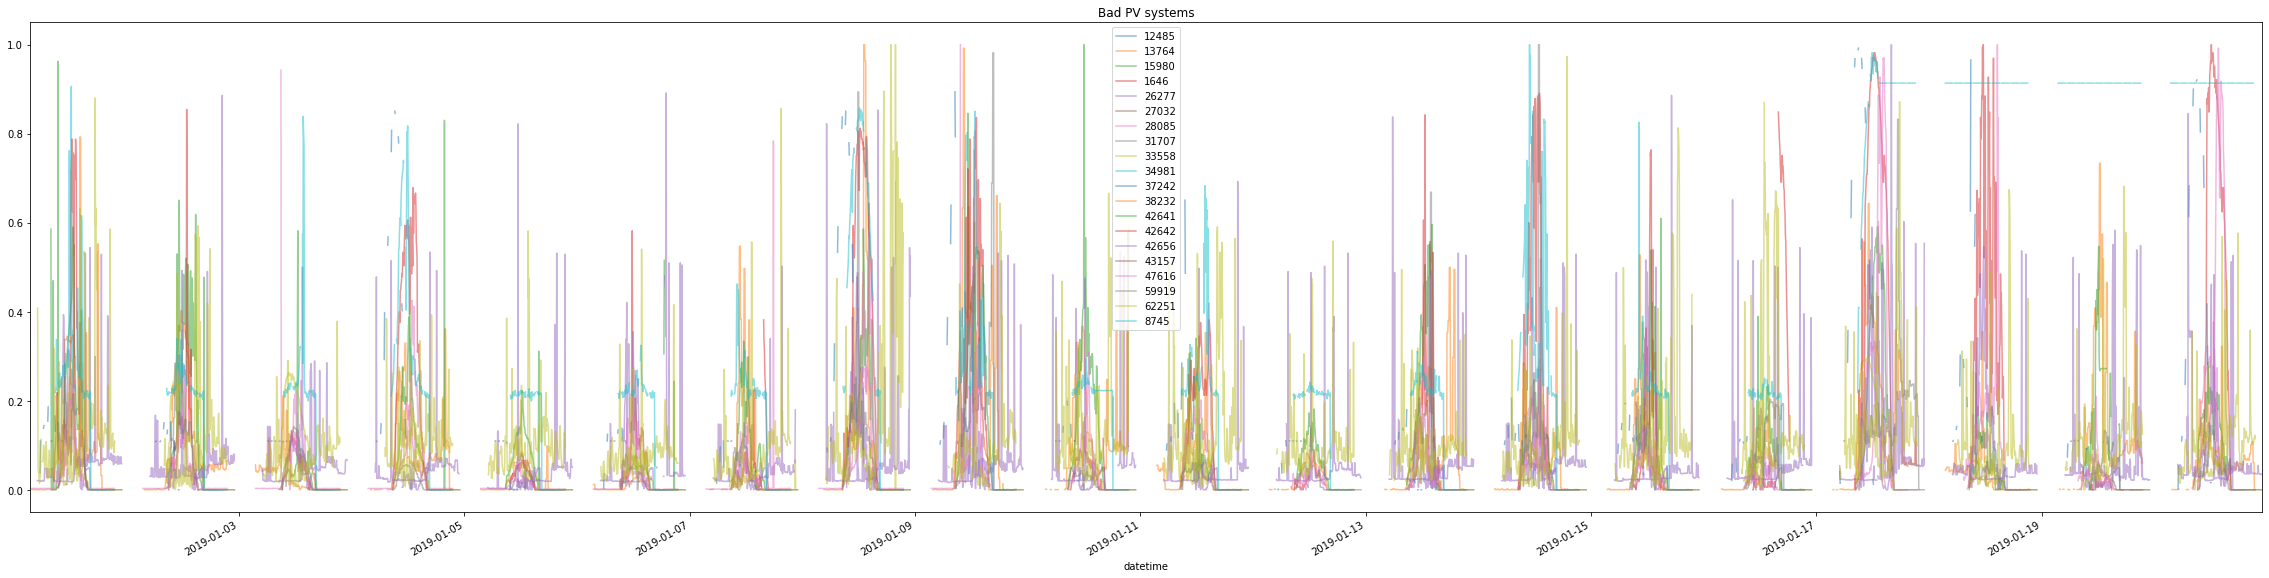

In [198]:
# Drop systems which are producing over night
bad_systems = np.where(
    (pv_power_df[pv_power_df.index.hour.isin(night_hours)] > 0.4).sum()
)[0]
bad_systems = pv_power_df.columns[bad_systems]
ax = pv_power_df[bad_systems].plot(figsize=(40, 10), alpha=0.5)
ax.set_title('Bad PV systems');

In [199]:
pv_power_df.drop(bad_systems, axis='columns', inplace=True)

In [200]:
# Interpolate
pv_power_df = pv_power_df.interpolate(limit=3)

In [201]:
len(pv_power_df.columns)

764

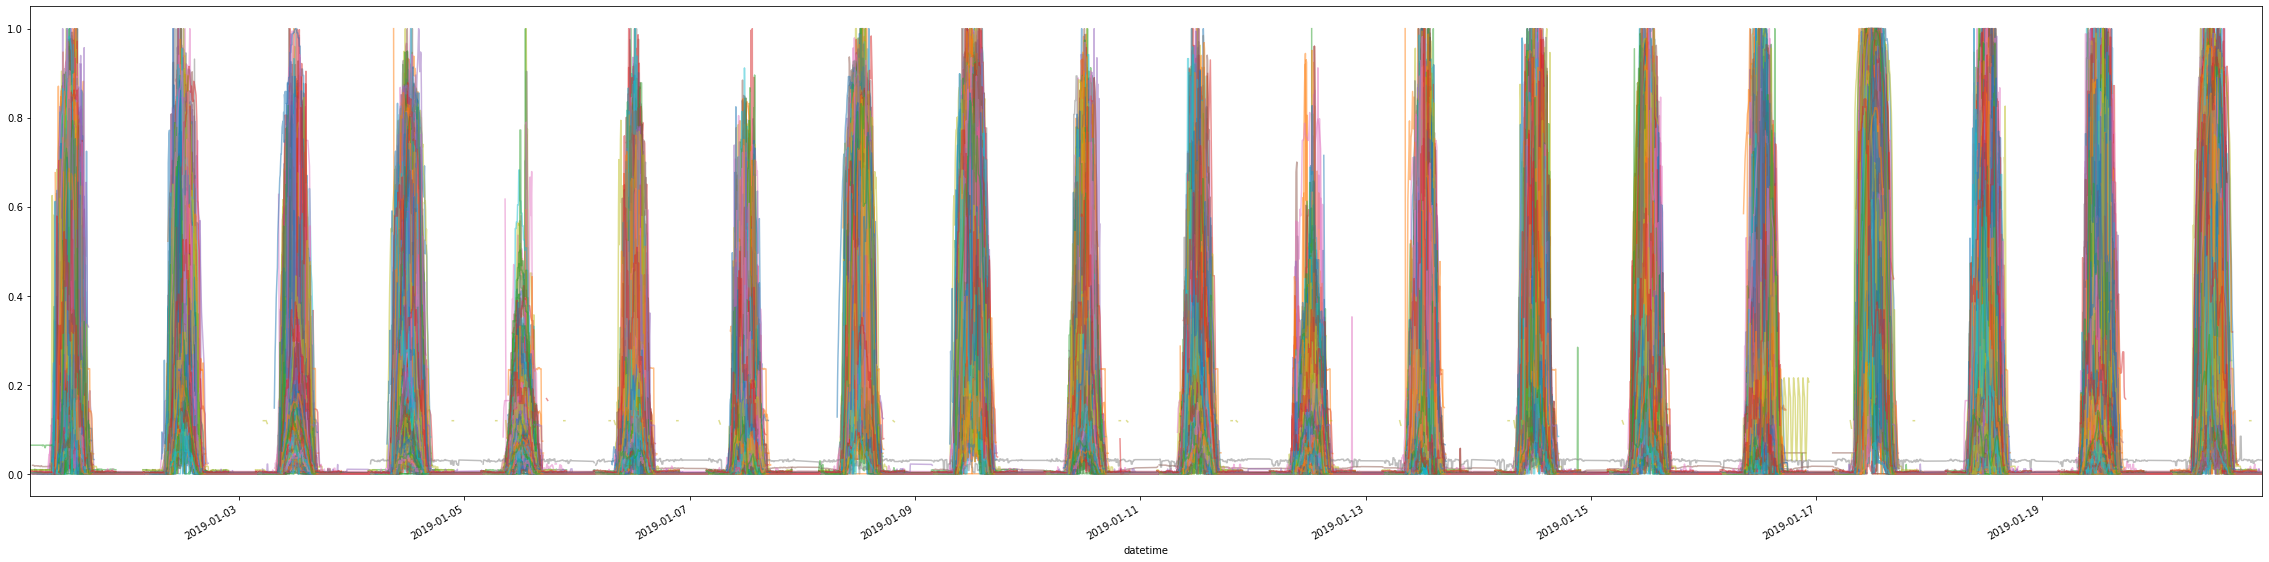

In [202]:
pv_power_df.plot(figsize=(40, 10), alpha=0.5, legend=False);

In [203]:
# Sort the metadata
pv_metadata = pv_metadata.loc[pv_power_df.columns]

/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


## Load satellite data

In [14]:
DAYS = range(1, 20)
HOURS = range(7, 17)
satellite_data_filenames = [
    os.path.join(SATELLITE_DATA_PATH, '2019-01-{:02d}T{:02d}.nc'.format(day, hour))
    for day, hour in list(product(DAYS, HOURS))]

In [15]:
%%time
dataset = xr.open_mfdataset(paths=satellite_data_filenames, concat_dim='time')
da = dataset['HRV']

CPU times: user 1.78 s, sys: 127 ms, total: 1.91 s
Wall time: 6.94 s


/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/jack/miniconda3/envs/predict_pv_yield/lib/python3.7/site-packages/xarray/backends/api.py:931: FutureWarning: Also `open_mfdataset` will no longer accept a `concat_dim` argument.
To get equivalent behaviour from now on please use the new
`combine_nested` function instead (or the `combine='nested'` option to
`open_mfdataset`).The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue 

In [204]:
def get_normalised_sat_array(i=0):
    data = da[i].loc[dict(x=slice(WEST, EAST), y=slice(SOUTH, NORTH))]
    data -= data.min()
    data /= data.max()
    return data

In [205]:
CMAP = cm.get_cmap('plasma')
def get_colors(dt):
    colors = pv_power_df.loc[dt]
    colors = np.ma.masked_array(colors, mask=colors.isna())
    return CMAP(colors)

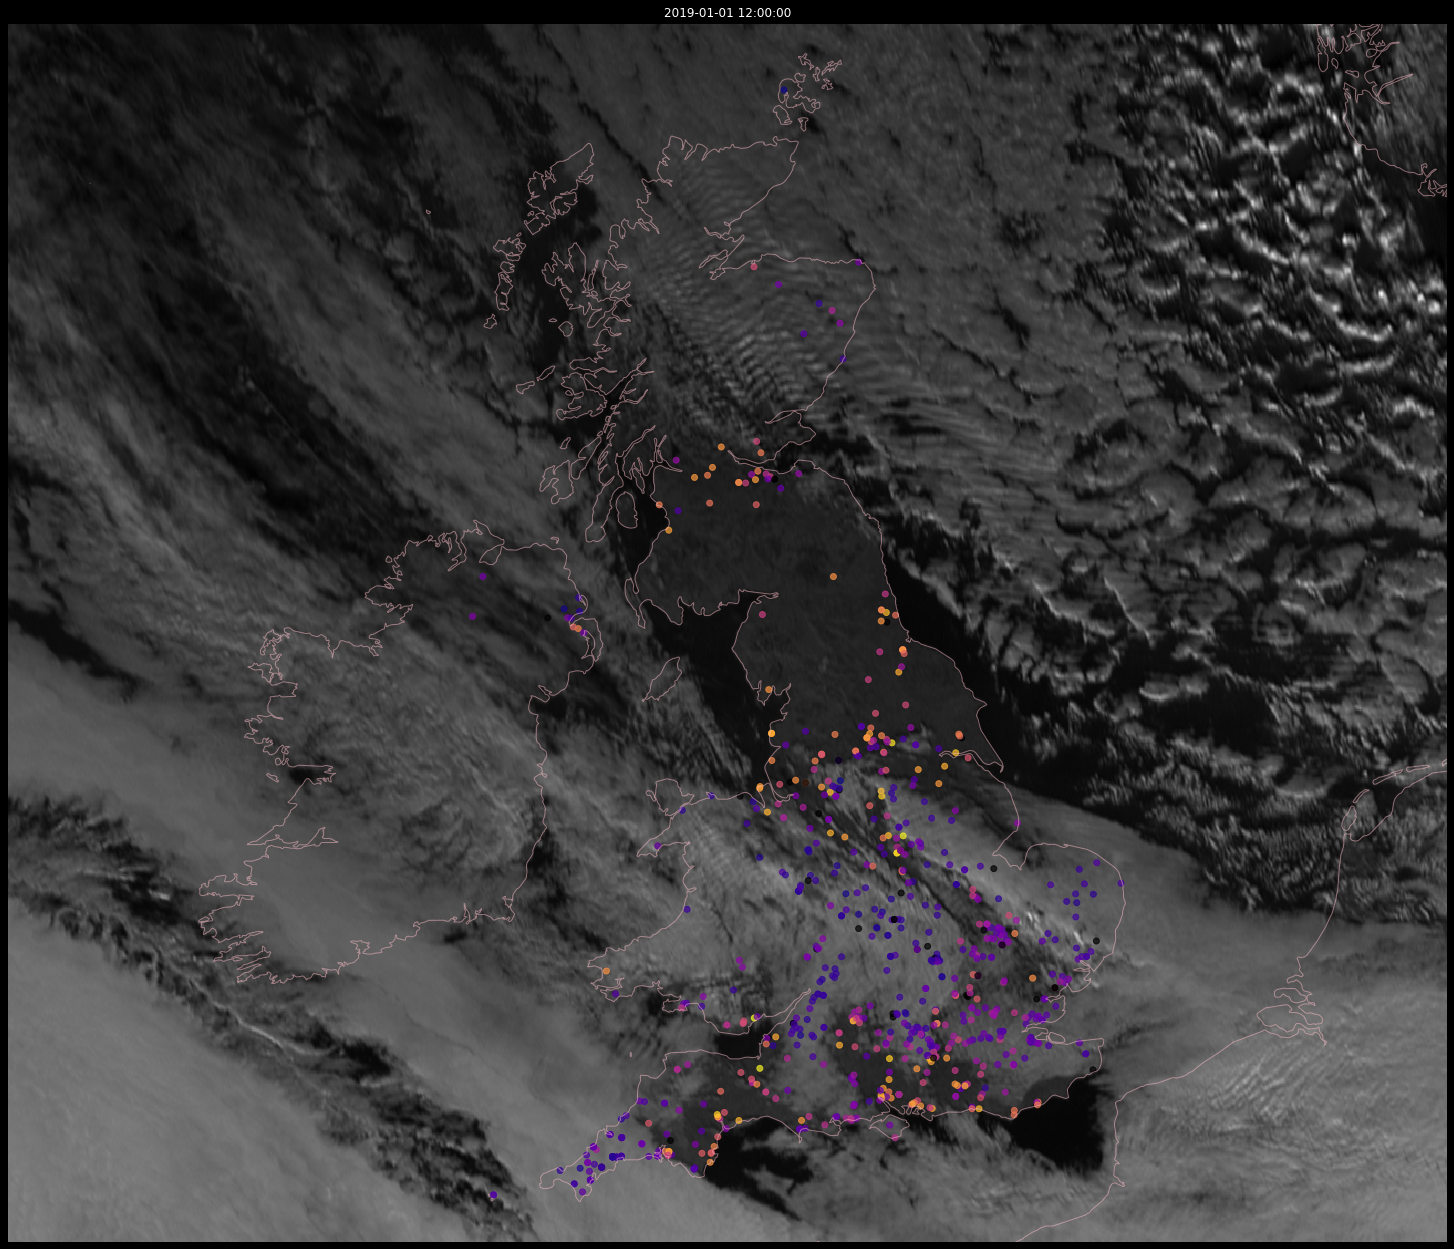

In [209]:
fig = plt.figure(figsize=(20, 20))
fig.patch.set_facecolor('black')
fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=None, hspace=None)
crs = ccrs.TransverseMercator()
ax = plt.axes(projection=crs)
ax.coastlines(resolution='10m', alpha=0.5, color='pink')

sat_data = get_normalised_sat_array()
img = sat_data.plot.imshow(ax=ax, cmap='gray', origin='upper', vmin=0, vmax=1, add_colorbar=False)
path_collection = ax.scatter(x=pv_metadata.x, y=pv_metadata.y, alpha=0.7)

def update(i):
    sat_data = get_normalised_sat_array(i)
    img.set_data(sat_data)
    dt = pd.Timestamp(sat_data.time.values)
    colors = get_colors(dt)
    path_collection.set_color(colors)
    ax.set_title(dt, color='white')

update(60)

In [ ]:
# Docs: https://matplotlib.org/3.1.1/api/animation_api.html#writer-classes
moviewriter = FFMpegFileWriter(
    fps=10, 
    bitrate=2000  # Produces average bitrate of 5.56 Mbps
)

with moviewriter.saving(fig, 'UK_PV_and_clouds_Jan2019.mp4', dpi=70):
    for i in np.arange(da.time.size):
        update(i)
        moviewriter.grab_frame(bbox_inches='tight', pad_inches=0, facecolor='black')